#**Project**: Data Analytics in Health Care & Connected Care
#              **Mortality Prediction Model for ICU patients with Heart Failure**
#              (Academic Year 2023/2024)



# Group Memembers

Saad Nazir: 0608573

Ghulam Mustafa Imran: 0611022

Momina Jamil: 0612857


Syed Fahim Haider Kazmi: 0610449


# Credentializing Colab

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Loading the data from Big Query

 Data is loaded from bigQuery and ready for making valueable dataset for analysis and model training.

**Extracting the codes of heart diseases from the mimic dataset.**

In [4]:
%%bigquery  --project fourth-fact-417009
select count(*) as Type_of_HeartFailures from `physionet-data.mimiciii_clinical.d_icd_diagnoses`
        where LONG_TITLE LIKE "%heart failure%" OR LONG_TITLE LIKE "Heart failure"

Query is running:   0%|          |

Downloading:   0%|          |

,Type_of_HeartFailures
0,33


**1. Getting the useful information from patients,diagnoses_icd,d_icd_diagnoses, chart events, d_items,icu_stay and admissions tables**

In [8]:
%%bigquery  dataset_p1 --project fourth-fact-417009

SELECT  d.SUBJECT_ID as Patient_ID, DATETIME_DIFF(a.ADMITTIME, p.DOB, YEAR) as age, p.GENDER, a.ETHNICITY, item.LABEL as Chart_label, ch.VALUENUM as Chart_Value,
    a.DIAGNOSIS, dc.LONG_TITLE as Type_of_Heart_Failure,icu.LOS,p.expire_flag,
FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses` dc
INNER JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` d ON d.ICD9_CODE = dc.ICD9_CODE
INNER JOIN `physionet-data.mimiciii_clinical.admissions` a
  ON a.SUBJECT_ID = d.SUBJECT_ID and a.HADM_ID = d.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.patients` p
   ON p.SUBJECT_ID = d.SUBJECT_ID
INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
 ON icu.SUBJECT_ID = d.SUBJECT_ID and a.HADM_ID = icu.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.chartevents` ch
   ON d.SUBJECT_ID = p.SUBJECT_ID and ch.HADM_ID = a.HADM_ID and ch.ICUSTAY_ID = icu.ICUSTAY_ID
INNER JOIN `physionet-data.mimiciii_clinical.d_items` item
   ON item.ITEMID = ch.ITEMID

WHERE (dc.LONG_TITLE LIKE "%heart failure%" OR dc.LONG_TITLE LIKE "%Heart failure%")
    and  DATETIME_DIFF(a.ADMITTIME, p.DOB, YEAR) BETWEEN 0 AND 100 and ch.VALUENUM is not null
ORDER BY d.SUBJECT_ID, d.HADM_ID LIMIT 1000000

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
dataset_p1

,Patient_ID,age,GENDER,ETHNICITY,Chart_label,Chart_Value,DIAGNOSIS,Type_of_Heart_Failure,LOS,expire_flag
0,3,76,M,WHITE,Low Exhaled Min Vol,6.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
1,3,76,M,WHITE,Arterial BP [Systolic],131.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
2,3,76,M,WHITE,Respiratory Rate,16.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
3,3,76,M,WHITE,Arterial BP [Systolic],97.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
4,3,76,M,WHITE,Heart Rate,64.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
...,...,...,...,...,...,...,...,...,...,...
999995,766,86,F,WHITE,NBP [Systolic],102.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999996,766,86,F,WHITE,Resp Alarm [High],35.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),4.9796,1
999997,766,86,F,WHITE,NBP Alarm [Low],90.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999998,766,86,F,WHITE,calprevflg,1.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),4.9796,1


In [10]:
%%bigquery  dataset_p2 --project fourth-fact-417009
SELECT d.SUBJECT_ID as Patient_ID, ilab.LABEL as Lab_label, lab.VALUENUM as LAB_value,
FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses` dc
INNER JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` d
      ON d.ICD9_CODE = dc.ICD9_CODE
INNER JOIN `physionet-data.mimiciii_clinical.labevents` lab
      ON lab.SUBJECT_ID = d.SUBJECT_ID and lab.HADM_ID = d.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.d_labitems` ilab
      ON ilab.ITEMID = lab.ITEMID

WHERE (dc.LONG_TITLE LIKE "%heart failure%" OR dc.LONG_TITLE LIKE "%Heart failure%")
      and d.SUBJECT_ID <= 766
      ORDER BY d.SUBJECT_ID, d.HADM_ID  LIMIT 1000000


Query is running:   0%|          |

Downloading:   0%|          |

In [200]:
dataset_p2

,Patient_ID,Lab_label,LAB_value
0,3,Oxygen Saturation,60.0
1,3,Base Excess,-4.0
2,3,Platelet Count,191.0
3,3,"Creatine Kinase, MB Isoenzyme",NaN
4,3,Oxygen,30.0
...,...,...,...
173189,766,MCHC,34.0
173190,766,MCV,100.0
173191,766,Calculated Total CO2,38.0
173192,766,MCV,94.0


# Feature Extraction from text data

In [201]:
import pandas as pd
#Create the data frames
df1 = pd.DataFrame(dataset_p1)
df2 = pd.DataFrame(dataset_p2)

In [202]:
extra_patients = []
for i in df2['Patient_ID'].unique():
  if i not in (df1['Patient_ID'].unique()):
    extra_patients.append(i)

**1. Vital Signs**

In [203]:
#Create the record list to store the data in a form of dictionary
record = []
# Use for loop for iterating over data frame
for patient_id in df1['Patient_ID'].unique():
    # Filter DataFrame for the current patient ID
    patient_record = df1[df1['Patient_ID'] == patient_id]

    #Store the vitals signs and their values in a list form
    labels = patient_record['Chart_label'].tolist()
    values = patient_record['Chart_Value'].tolist()

    # Create a dictionary for each attribute-value pair
    for label, value in zip(labels, values):
        record.append({
            'Patient_ID': patient_id,
            'Vital_signs': label,
            'Value': value
        })

# Convert the record dictionary into a data frame
temp_df = pd.DataFrame(record)

#Drop the columns from which we extracted features
temp_df = temp_df.drop_duplicates(subset=['Patient_ID', 'Vital_signs'])

# Pivot the data frame with Patient_ID as index,  vital_signs as coulmn and Value to populate these columns
temp_df = temp_df.pivot(index='Patient_ID', columns='Vital_signs', values='Value').reset_index()


In [204]:
temp_df

Vital_signs,Patient_ID,16 Gauge Dressing Occlusive,16 Gauge placed in outside facility,16 Gauge placed in the field,18 Gauge Dressing Occlusive,18 Gauge placed in outside facility,18 Gauge placed in the field,20 Gauge Dressing Occlusive,20 Gauge placed in outside facility,20 Gauge placed in the field,...,calprevflg,disconect alarm,driving pressure,high VE,high min volume,high mv,high ve,solumedrol mg/kg/hr,zzO2AV,zzO2AVI
0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,747,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566.799988,322.158997


In [205]:
#Count the null for each column
temp_df.isna().sum()

Vital_signs
Patient_ID                               0
16 Gauge Dressing Occlusive            163
16 Gauge placed in outside facility    163
16 Gauge placed in the field           164
18 Gauge Dressing Occlusive            156
                                      ... 
high mv                                162
high ve                                163
solumedrol mg/kg/hr                    165
zzO2AV                                 136
zzO2AVI                                136
Length: 810, dtype: int64

Weight and Height of Patients

In [206]:
temp_df['Admission Weight (lbs.)'].isna().sum()

153

In [207]:
temp_df['Admit Wt'].isna().sum()

34

In [208]:
temp_df['Admit Ht'].isna().sum()

77

In [209]:
#Removing the columns that contain more null values
null_values = temp_df.isna().sum()
vital_sign = null_values[null_values<15].index
#Weight and Height are the important features so we keep them
vital_sign_2 = ['Admit Wt','Admit Ht'] + vital_sign.to_list()
vital_signs = temp_df.loc[:,vital_sign_2]
vital_signs

Vital_signs,Admit Wt,Admit Ht,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,...,Motor Response,Platelets,Potassium (3.5-5.3),Respiratory Rate,Sodium (135-148),SpO2,Temperature C (calc),Temperature F,Verbal Response,calprevflg
0,96.800003,70.5,3,36.0,11.0,11.0,108.0,2.4,4.0,10.0,...,6.0,253.0,4.1,16.0,139.0,98.0,36.166698,99.800003,1.0,1.0
1,104.000000,72.0,9,17.0,10.0,24.0,99.0,2.0,1.0,3.0,...,1.0,330.0,3.8,23.0,137.0,97.0,36.833302,97.199997,1.0,1.0
2,65.599998,69.0,21,71.0,13.0,17.0,100.0,2.4,4.0,14.0,...,6.0,273.0,3.6,28.0,139.0,100.0,35.388901,98.699997,5.0,1.0
3,NaN,NaN,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,...,6.0,159.0,4.5,16.0,138.0,96.0,36.500000,99.000000,5.0,1.0
4,NaN,NaN,37,25.0,14.0,35.0,100.0,0.8,4.0,14.0,...,6.0,310.0,4.0,23.0,143.0,97.0,36.833302,100.400002,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,70.000000,66.0,744,14.0,15.0,19.0,109.0,0.8,4.0,15.0,...,6.0,142.0,4.0,18.0,141.0,99.0,36.555599,97.800003,5.0,1.0
162,NaN,NaN,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
163,136.000000,66.0,751,29.0,14.0,18.0,110.0,1.7,4.0,15.0,...,6.0,107.0,3.4,26.0,146.0,95.0,35.722198,98.800003,5.0,1.0
164,69.099998,60.0,754,9.0,14.0,25.0,109.0,0.4,4.0,15.0,...,6.0,270.0,3.4,14.0,137.0,100.0,36.888901,97.000000,5.0,1.0


**Calculate BMI**

In [210]:
#Covert the height into meters from inches
temp_df['Height'] = temp_df['Admit Ht'] * 0.0254
#Calculate the BMI for each patient
vital_signs.loc[:,'BMI'] = temp_df['Admit Wt'] / (temp_df['Height'] ** 2)
vital_signs

Vital_signs,Admit Wt,Admit Ht,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,...,Platelets,Potassium (3.5-5.3),Respiratory Rate,Sodium (135-148),SpO2,Temperature C (calc),Temperature F,Verbal Response,calprevflg,BMI
0,96.800003,70.5,3,36.0,11.0,11.0,108.0,2.4,4.0,10.0,...,253.0,4.1,16.0,139.0,98.0,36.166698,99.800003,1.0,1.0,30.187678
1,104.000000,72.0,9,17.0,10.0,24.0,99.0,2.0,1.0,3.0,...,330.0,3.8,23.0,137.0,97.0,36.833302,97.199997,1.0,1.0,31.095741
2,65.599998,69.0,21,71.0,13.0,17.0,100.0,2.4,4.0,14.0,...,273.0,3.6,28.0,139.0,100.0,35.388901,98.699997,5.0,1.0,21.356900
3,NaN,NaN,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,...,159.0,4.5,16.0,138.0,96.0,36.500000,99.000000,5.0,1.0,NaN
4,NaN,NaN,37,25.0,14.0,35.0,100.0,0.8,4.0,14.0,...,310.0,4.0,23.0,143.0,97.0,36.833302,100.400002,5.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,70.000000,66.0,744,14.0,15.0,19.0,109.0,0.8,4.0,15.0,...,142.0,4.0,18.0,141.0,99.0,36.555599,97.800003,5.0,1.0,24.908222
162,NaN,NaN,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,136.000000,66.0,751,29.0,14.0,18.0,110.0,1.7,4.0,15.0,...,107.0,3.4,26.0,146.0,95.0,35.722198,98.800003,5.0,1.0,48.393118
164,69.099998,60.0,754,9.0,14.0,25.0,109.0,0.4,4.0,15.0,...,270.0,3.4,14.0,137.0,100.0,36.888901,97.000000,5.0,1.0,29.751448


Deleting the columns of height and weight as it has been used in BMI columns while

In [211]:
vital_signs.drop(columns=['Admit Wt','Admit Ht','calprevflg'], inplace= True)

In [212]:
vital_signs.isna().sum()

Vital_signs
Patient_ID               0
BUN (6-20)              12
Braden Score            13
Carbon Dioxide          13
Chloride (100-112)      12
Creatinine (0-1.3)      12
Eye Opening             12
GCS Total               12
Glucose (70-105)        11
Heart Rate               1
Hematocrit              14
Hemoglobin               5
Motor Response          12
Platelets               14
Potassium (3.5-5.3)     11
Respiratory Rate         1
Sodium (135-148)        11
SpO2                    12
Temperature C (calc)    14
Temperature F           14
Verbal Response         12
BMI                     77
dtype: int64

**2. Lab Events**

In [213]:
#Create the lab record list to store the data in a form of dictionary
lab_record = []
# Use for loop for iterating over data frame
for patient_id in df2['Patient_ID'].unique():
    # Filter DataFrame for the current patient ID
    patient_record = df2[df2['Patient_ID'] == patient_id]

    #Store the Laboratory Variables and their values in a list form
    labels = patient_record['Lab_label'].tolist()
    values = patient_record['LAB_value'].tolist()

    # Create a dictionary for each attribute-value pair
    for label, value in zip(labels, values):
        record.append({
            'Patient_ID': patient_id,
            'Laboratory Variables': label,
            'Value': value
        })

# Convert the record dictionary into a data frame
temp_df2 = pd.DataFrame(record)

#Drop the columns from which we extracted features
temp_df2 = temp_df2.drop_duplicates(subset=['Patient_ID', 'Laboratory Variables'])

# Pivot the data frame with Patient_ID as index,  Laboratory Variables as coulmn and Value to populate these columns
temp_df2 = temp_df2.pivot(index='Patient_ID', columns='Laboratory Variables', values='Value').reset_index()



In [214]:
temp_df2

Laboratory Variables,Patient_ID,NaN,% Hemoglobin A1c,24 hr Creatinine,24 hr Protein,Absolute A1c,Absolute CD3 Count,Absolute CD4 Count,Absolute CD8 Count,Absolute Hemoglobin,...,"WBC, Other Fluid","WBC, Pleural",Waxy Casts,White Blood Cells,Wright Giemsa,Yeast,pCO2,pH,pO2,tacroFK
0,3,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.5,NaN,NaN,27.0,7.42,96.0,NaN
1,9,13.1,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.2,NaN,NaN,36.0,7.39,166.0,NaN
2,21,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21.0,NaN,NaN,47.0,7.34,97.0,NaN
3,26,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.7,NaN,NaN,NaN,5.00,NaN,NaN
4,30,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11.6,NaN,NaN,29.0,5.50,90.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,744,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.1,NaN,NaN,NaN,NaN,NaN,NaN
179,747,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.9,NaN,NaN,75.0,7.28,77.0,NaN
180,751,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.7,NaN,NaN,37.0,5.00,313.0,NaN
181,754,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.6,NaN,NaN,40.0,6.50,205.0,NaN


In [215]:
temp_df2.isna().sum()

Laboratory Variables
Patient_ID            0
NaN                  17
% Hemoglobin A1c    152
24 hr Creatinine    181
24 hr Protein       182
                   ... 
Yeast               182
pCO2                 27
pH                   10
pO2                  27
tacroFK             181
Length: 348, dtype: int64

In [216]:
null_values = temp_df2.isna().sum()
#Only those columns are selected which have less than 25 null values
selected_col = null_values[null_values<17].index
laboratory_variables = temp_df2[selected_col]
laboratory_variables

Laboratory Variables,Patient_ID,Anion Gap,Bicarbonate,"Calcium, Total",Chloride,Creatinine,Hematocrit,Hemoglobin,INR(PT),MCH,...,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Urea Nitrogen,White Blood Cells,pH
0,3,14.0,23.0,7.5,110.0,1.5,30.9,12.1,1.5,29.1,...,62.3,2.5,191.0,3.9,15.7,2.79,139.0,17.0,10.5,7.42
1,9,13.0,21.0,9.1,100.0,1.6,45.2,13.0,1.1,29.6,...,22.8,5.3,330.0,3.0,14.6,4.44,130.0,22.0,12.2,7.39
2,21,22.0,19.0,8.2,102.0,4.0,32.4,10.7,1.8,28.4,...,49.4,7.1,275.0,3.8,18.1,3.43,137.0,102.0,21.0,7.34
3,26,12.0,24.0,8.5,102.0,1.3,32.5,12.1,1.3,32.2,...,22.8,2.8,159.0,4.0,13.3,3.82,138.0,28.0,7.7,5.00
4,30,18.0,20.0,9.0,97.0,2.0,27.6,9.0,1.2,30.5,...,32.7,3.5,211.0,4.4,13.3,3.16,136.0,50.0,11.6,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,744,12.0,24.0,7.4,110.0,0.8,28.9,10.4,1.4,32.8,...,30.6,1.7,137.0,4.4,14.1,3.05,141.0,14.0,8.1,NaN
179,747,8.0,38.0,9.7,104.0,1.7,34.4,10.2,3.3,26.9,...,38.1,4.8,213.0,5.1,17.8,3.78,145.0,53.0,13.9,7.28
180,751,14.0,21.0,8.6,105.0,1.1,29.7,10.5,1.4,26.4,...,28.8,3.7,167.0,3.8,15.9,3.77,135.0,18.0,5.7,5.00
181,754,8.0,24.0,8.8,104.0,0.4,29.4,9.4,2.5,28.1,...,74.9,3.0,330.0,3.7,15.0,3.72,140.0,9.0,6.6,6.50


In [217]:
laboratory_variables.isna().sum()

Laboratory Variables
Patient_ID            0
Anion Gap             1
Bicarbonate           2
Calcium, Total        3
Chloride              1
Creatinine            1
Hematocrit            1
Hemoglobin            0
INR(PT)               5
MCH                   1
MCHC                  1
MCV                   1
Magnesium             2
PT                    5
PTT                   5
Phosphate             3
Platelet Count        0
Potassium             1
RDW                   1
Red Blood Cells       1
Sodium                1
Urea Nitrogen         1
White Blood Cells     1
pH                   10
dtype: int64

In [218]:
laboratory_variables.columns

Index(['Patient_ID', 'Anion Gap', 'Bicarbonate', 'Calcium, Total', 'Chloride',
       'Creatinine', 'Hematocrit', 'Hemoglobin', 'INR(PT)', 'MCH', 'MCHC',
       'MCV', 'Magnesium', 'PT', 'PTT', 'Phosphate', 'Platelet Count',
       'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Urea Nitrogen',
       'White Blood Cells', 'pH'],
      dtype='object', name='Laboratory Variables')

# Dealing with catagorical data

In [219]:
#RTemoving the redundant data
columns_to_drop1 = ['Chart_label','Chart_Value']
df1_min = df1.drop(columns_to_drop1,axis=1)

In [220]:
df1_min

,Patient_ID,age,GENDER,ETHNICITY,DIAGNOSIS,Type_of_Heart_Failure,LOS,expire_flag
0,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
1,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
2,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
3,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
4,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
...,...,...,...,...,...,...,...,...
999995,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999996,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),4.9796,1
999997,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999998,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),4.9796,1


**Handling with categorical data**

In [222]:
columns_to_be_encoded = ['Type_of_Heart_Failure',	'GENDER', 'ETHNICITY',	'DIAGNOSIS']

for column in columns_to_be_encoded:
    # Get the values from the columns
    column_values = df1_min[column]
    # Initialize LabelEncoder
    encoder = LabelEncoder()
    # Transform the text values to integer
    column_encoded= encoder.fit_transform(column_values)
    # Add the new integer encoded values into data frame
    df1_min[column] = column_encoded
    column_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))


In [223]:
df1_encoded= df1_min.drop_duplicates(subset= 'Patient_ID')

In [224]:
df1_encoded['GENDER'].value_counts()

GENDER
1    90
0    76
Name: count, dtype: int64

In [225]:
df1_encoded

,Patient_ID,age,GENDER,ETHNICITY,DIAGNOSIS,Type_of_Heart_Failure,LOS,expire_flag
0,3,76,1,8,81,9,6.0646,1
3280,9,41,1,7,78,9,5.3231,1
6343,21,87,1,8,48,9,5.9017,1
10367,26,72,1,7,141,9,2.1407,1
10976,37,69,1,8,48,9,1.1397,1
...,...,...,...,...,...,...,...,...
988193,744,82,1,8,57,9,1.2681,0
988664,747,84,1,8,48,9,0.5035,1
988811,751,56,1,8,115,1,7.1434,1
993780,754,73,0,3,144,9,5.0418,0


# Merged into a single data frame

In [226]:
merged_df = pd.merge(vital_signs,laboratory_variables,on = 'Patient_ID', how ='inner')
merged_df

,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,Glucose (70-105),Heart Rate,...,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Urea Nitrogen,White Blood Cells,pH
0,3,36.0,11.0,11.0,108.0,2.4,4.0,10.0,128.0,64.0,...,62.3,2.5,191.0,3.9,15.7,2.79,139.0,17.0,10.5,7.42
1,9,17.0,10.0,24.0,99.0,2.0,1.0,3.0,170.0,87.0,...,22.8,5.3,330.0,3.0,14.6,4.44,130.0,22.0,12.2,7.39
2,21,71.0,13.0,17.0,100.0,2.4,4.0,14.0,128.0,163.0,...,49.4,7.1,275.0,3.8,18.1,3.43,137.0,102.0,21.0,7.34
3,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,129.0,74.0,...,22.8,2.8,159.0,4.0,13.3,3.82,138.0,28.0,7.7,5.00
4,37,25.0,14.0,35.0,100.0,0.8,4.0,14.0,74.0,74.0,...,25.2,3.9,310.0,4.2,15.2,3.78,143.0,40.0,13.3,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,744,14.0,15.0,19.0,109.0,0.8,4.0,15.0,134.0,93.0,...,30.6,1.7,137.0,4.4,14.1,3.05,141.0,14.0,8.1,NaN
162,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,...,38.1,4.8,213.0,5.1,17.8,3.78,145.0,53.0,13.9,7.28
163,751,29.0,14.0,18.0,110.0,1.7,4.0,15.0,120.0,67.0,...,28.8,3.7,167.0,3.8,15.9,3.77,135.0,18.0,5.7,5.00
164,754,9.0,14.0,25.0,109.0,0.4,4.0,15.0,119.0,54.0,...,74.9,3.0,330.0,3.7,15.0,3.72,140.0,9.0,6.6,6.50


In [227]:
final_df = pd.merge(merged_df,df1_encoded, on = 'Patient_ID', how = 'inner')
final_df

,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,Glucose (70-105),Heart Rate,...,Urea Nitrogen,White Blood Cells,pH,age,GENDER,ETHNICITY,DIAGNOSIS,Type_of_Heart_Failure,LOS,expire_flag
0,3,36.0,11.0,11.0,108.0,2.4,4.0,10.0,128.0,64.0,...,17.0,10.5,7.42,76,1,8,81,9,6.0646,1
1,9,17.0,10.0,24.0,99.0,2.0,1.0,3.0,170.0,87.0,...,22.0,12.2,7.39,41,1,7,78,9,5.3231,1
2,21,71.0,13.0,17.0,100.0,2.4,4.0,14.0,128.0,163.0,...,102.0,21.0,7.34,87,1,8,48,9,5.9017,1
3,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,129.0,74.0,...,28.0,7.7,5.00,72,1,7,141,9,2.1407,1
4,37,25.0,14.0,35.0,100.0,0.8,4.0,14.0,74.0,74.0,...,40.0,13.3,5.00,69,1,8,48,9,1.1397,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,744,14.0,15.0,19.0,109.0,0.8,4.0,15.0,134.0,93.0,...,14.0,8.1,NaN,82,1,8,57,9,1.2681,0
162,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,...,53.0,13.9,7.28,84,1,8,48,9,0.5035,1
163,751,29.0,14.0,18.0,110.0,1.7,4.0,15.0,120.0,67.0,...,18.0,5.7,5.00,56,1,8,115,1,7.1434,1
164,754,9.0,14.0,25.0,109.0,0.4,4.0,15.0,119.0,54.0,...,9.0,6.6,6.50,73,0,3,144,9,5.0418,0


# Handling the missing values

In [233]:
final_df.isna().sum()

Patient_ID                0
BUN (6-20)               12
Braden Score             13
Carbon Dioxide           13
Chloride (100-112)       12
Creatinine (0-1.3)       12
Eye Opening              12
GCS Total                12
Glucose (70-105)         11
Heart Rate                1
Hematocrit_x             14
Hemoglobin_x              5
Motor Response           12
Platelets                14
Potassium (3.5-5.3)      11
Respiratory Rate          1
Sodium (135-148)         11
SpO2                     12
Temperature C (calc)     14
Temperature F            14
Verbal Response          12
BMI                      77
Anion Gap                 1
Bicarbonate               2
Calcium, Total            3
Chloride                  1
Creatinine                1
Hematocrit_y              1
Hemoglobin_y              0
INR(PT)                   5
MCH                       1
MCHC                      1
MCV                       1
Magnesium                 2
PT                        5
PTT                 

In [243]:
#Store all the null values in a list
null_dealer = final_df.isna().sum().sort_values(ascending=False)
null_list = []
for i,value in null_dealer.items():
  if value >=1:
    null_list.append(i)

In [244]:
skew_values = final_df[null_list].skew()
#Convert the skew list into a data frame for better understanding of data
skew_df = pd.DataFrame(skew_values)
skew_df

,0
BMI,1.232369
Hematocrit_x,0.233406
Temperature F,0.063527
Temperature C (calc),0.163334
Platelets,1.023610
Braden Score,0.595293
Carbon Dioxide,-0.051944
SpO2,-1.951885
BUN (6-20),1.477537
Motor Response,-2.503778


In [ ]:
high_skew_cols = skew_df[abs(skew_df[0]) > 1].index

# Applying log transformation to columns with high skewness
for col in high_skew_cols:
    final_df[col] = np.log1p(final_df[col])

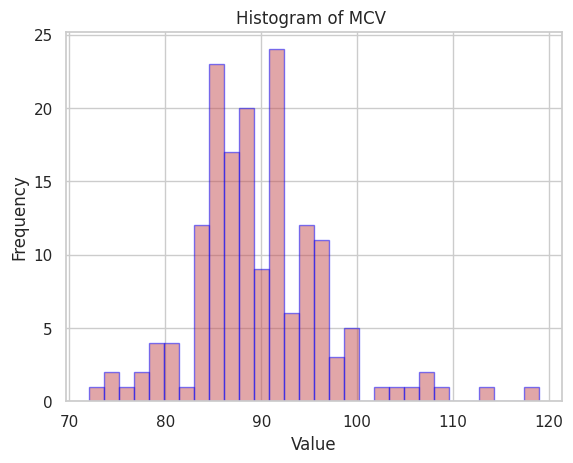

In [ ]:
plt.hist(final_df['MCV'], bins=30, alpha=0.5, color='r', edgecolor='blue')
plt.title("Histogram of MCV ")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

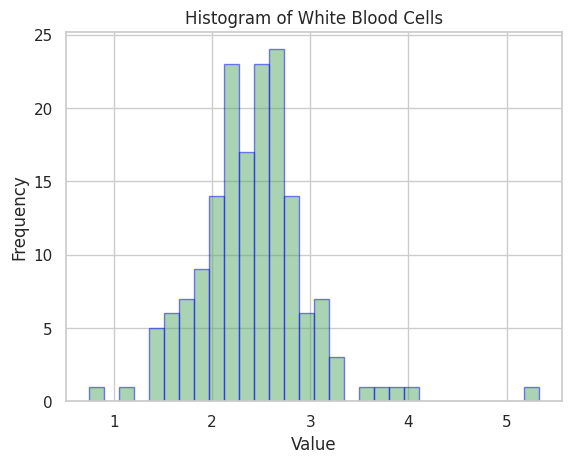

In [ ]:
plt.hist(final_df['White Blood Cells'], bins=30, alpha=0.5, color='g', edgecolor='blue')
plt.title("Histogram of White Blood Cells")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

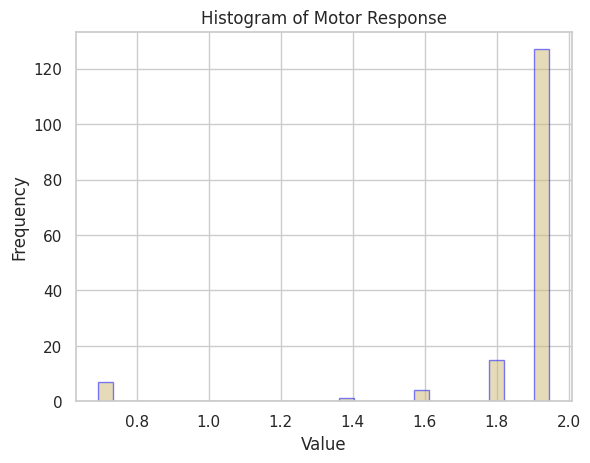

In [ ]:
plt.hist(final_df['Motor Response'], bins=30, alpha=0.5, color='y', edgecolor='blue')
plt.title("Histogram of Motor Response")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

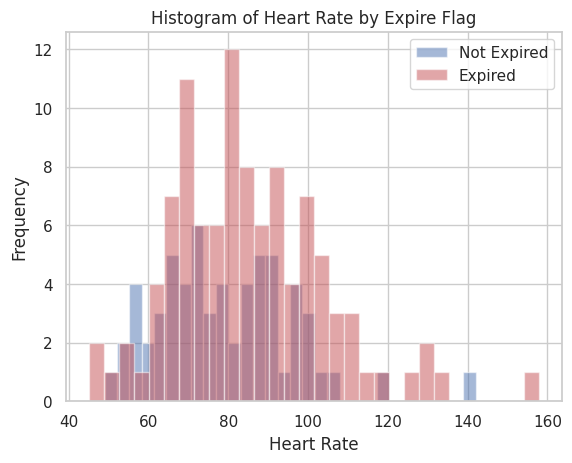

In [ ]:
import matplotlib.pyplot as plt

plt.hist(final_df[final_df['expire_flag'] == 0]['Heart Rate'], bins=30, alpha=0.5, color='b', label='Not Expired')
plt.hist(final_df[final_df['expire_flag'] == 1]['Heart Rate'], bins=30, alpha=0.5, color='r', label='Expired')
plt.title("Histogram of Heart Rate by Expire Flag")
plt.xlabel("Heart Rate")
plt.ylabel("Frequency")
plt.legend()
plt.show()

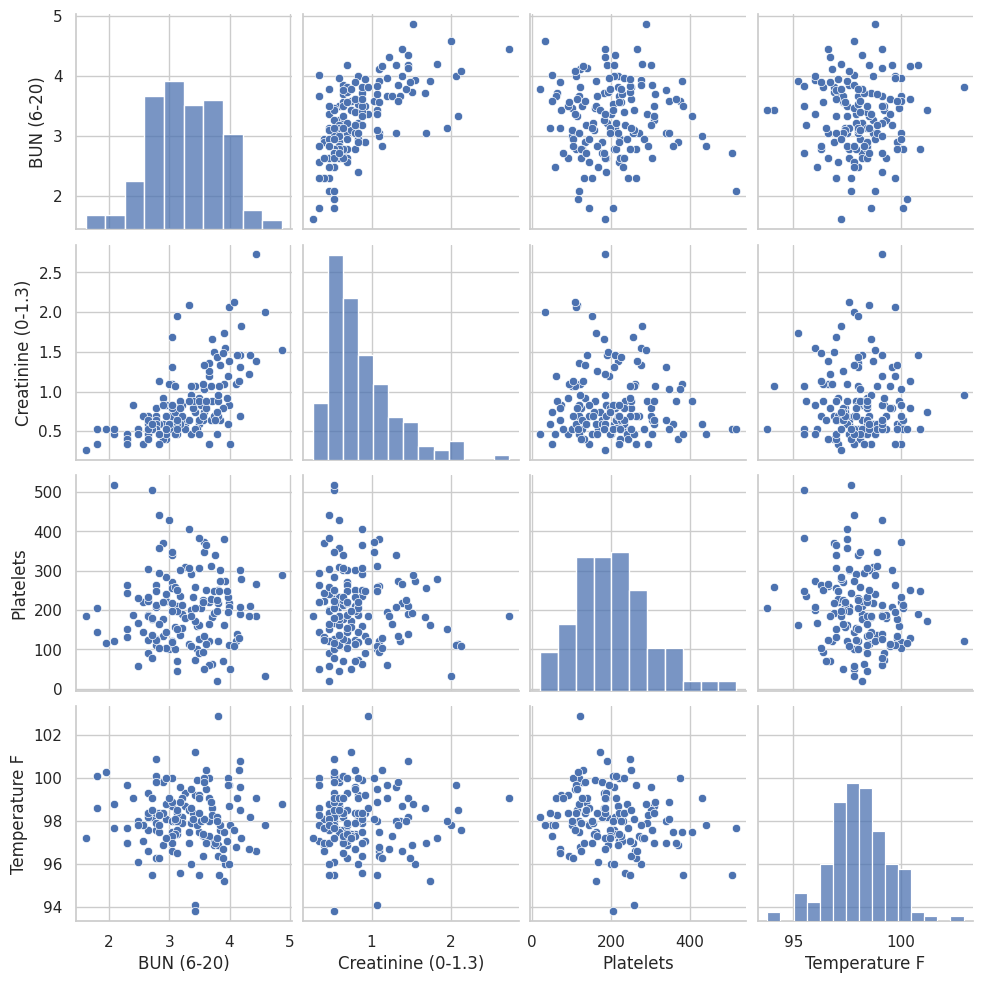

In [ ]:
sns.pairplot(final_df[['BUN (6-20)', 'Creatinine (0-1.3)', 'Platelets', 'Temperature F']])
plt.show()

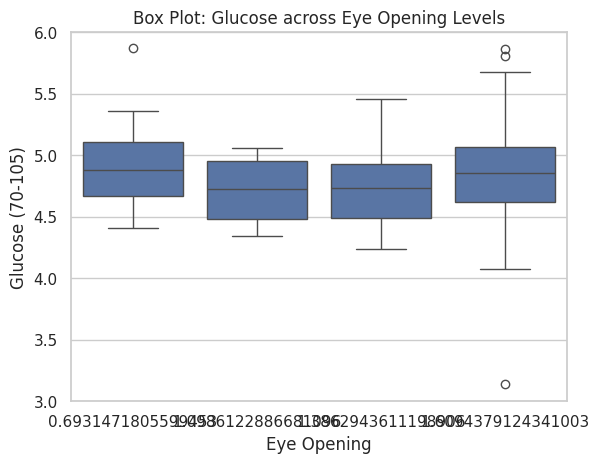

In [ ]:
import seaborn as sns
sns.boxplot(x='Eye Opening', y='Glucose (70-105)', data=final_df)
plt.title("Box Plot: Glucose across Eye Opening Levels")
plt.xlabel("Eye Opening")
plt.ylabel("Glucose (70-105)")
plt.show()


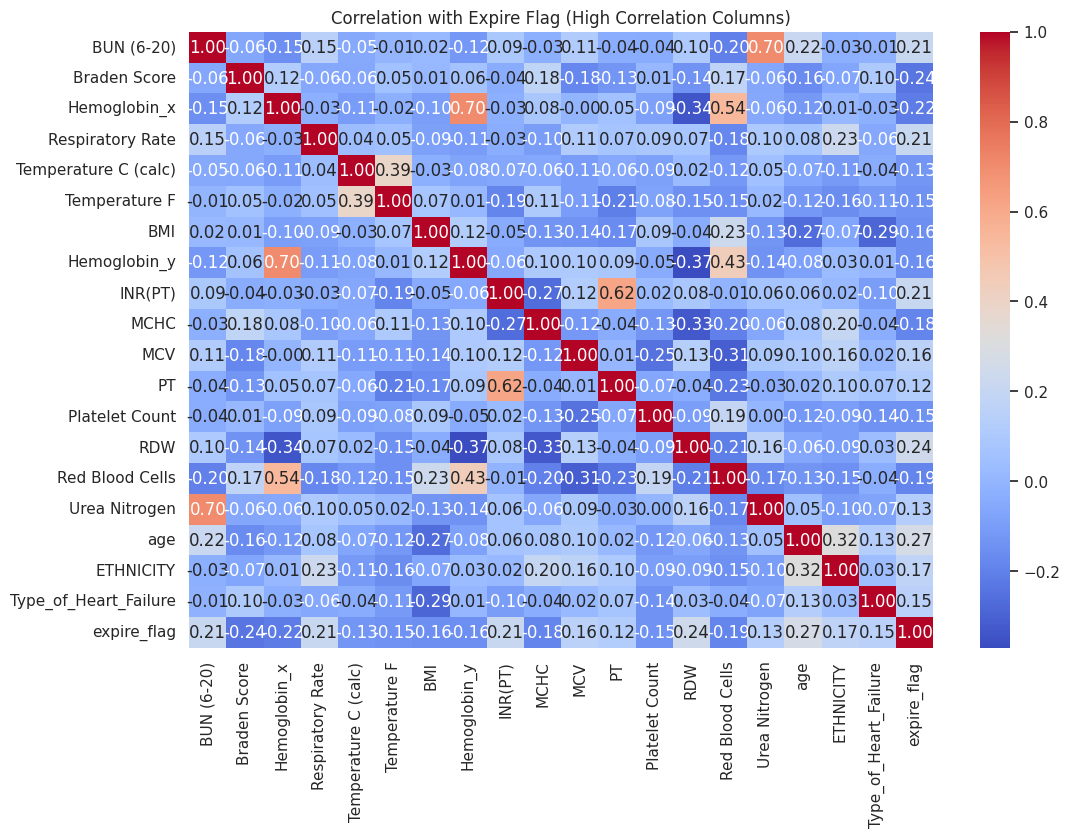

In [183]:
# Calculating the correlation matrix
corr_matrix = final_df.corr()

# Filtering out columns with low correlation with 'expire_flag' as toomany columns to display
threshold = 0.12
high_corr_columns = corr_matrix.index[abs(corr_matrix['expire_flag']) > threshold]

high_corr_matrix = final_df[high_corr_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation with Expire Flag (High Correlation Columns)')
plt.show()

In [184]:
sorted_corr = corr_matrix['expire_flag'].abs().sort_values(ascending=False)

# Select the top correlated columns (excluding the 'expire_flag' itself)
top_corr_columns = sorted_corr[1:]  # Exclude the 'expire_flag' column itself

top_corr_columns

age                      0.267992
RDW                      0.241583
Braden Score             0.238299
Hemoglobin_x             0.216761
Respiratory Rate         0.211188
BUN (6-20)               0.208925
INR(PT)                  0.208780
Red Blood Cells          0.188445
MCHC                     0.184727
ETHNICITY                0.173292
Hemoglobin_y             0.156342
MCV                      0.155763
BMI                      0.155352
Type_of_Heart_Failure    0.150607
Temperature F            0.145627
Platelet Count           0.145560
Urea Nitrogen            0.131628
Temperature C (calc)     0.128070
PT                       0.120531
Hematocrit_y             0.100147
White Blood Cells        0.099138
Calcium, Total           0.098600
Heart Rate               0.093339
Potassium                0.089228
Verbal Response          0.088387
Creatinine (0-1.3)       0.085800
GENDER                   0.084624
pH                       0.074916
Phosphate                0.067874
Eye Opening   

In [185]:
#Calculate the meann of data frames
mean = final_df.mean()
mean

Patient_ID               406.668675
BUN (6-20)                31.974026
Braden Score              14.222222
Carbon Dioxide            25.215686
Chloride (100-112)       104.149351
Creatinine (0-1.3)         1.572078
Eye Opening                3.571429
GCS Total                 12.850649
Glucose (70-105)         137.309677
Heart Rate                84.509091
Hematocrit_x              31.110526
Hemoglobin_x              10.495652
Motor Response             5.389610
Platelets                209.842105
Potassium (3.5-5.3)        4.178065
Respiratory Rate          19.800000
Sodium (135-148)         138.541935
SpO2                      97.006494
Temperature C (calc)      36.758406
Temperature F             98.145855
Verbal Response            3.733766
BMI                       27.715030
Anion Gap                 14.018182
Bicarbonate               25.902439
Calcium, Total             8.372393
Chloride                 102.515152
Creatinine                 1.586667
Hematocrit_y              31

In [186]:
# Imputing missing values for numeric columns with mean
numeric_cols = final_df.select_dtypes(include=np.number).columns
final_df[numeric_cols] = final_df[numeric_cols].fillna(final_df[numeric_cols].mean())

# Checking if there are missing values in categorical columns
categorical_cols = final_df.select_dtypes(include='object').columns
if not final_df[categorical_cols].empty:
    # Imputing missing values for categorical columns with mode
    final_df[categorical_cols] = final_df[categorical_cols].fillna(final_df[categorical_cols].mode().iloc[0])

print(final_df.isna().sum())

Patient_ID               0
BUN (6-20)               0
Braden Score             0
Carbon Dioxide           0
Chloride (100-112)       0
Creatinine (0-1.3)       0
Eye Opening              0
GCS Total                0
Glucose (70-105)         0
Heart Rate               0
Hematocrit_x             0
Hemoglobin_x             0
Motor Response           0
Platelets                0
Potassium (3.5-5.3)      0
Respiratory Rate         0
Sodium (135-148)         0
SpO2                     0
Temperature C (calc)     0
Temperature F            0
Verbal Response          0
BMI                      0
Anion Gap                0
Bicarbonate              0
Calcium, Total           0
Chloride                 0
Creatinine               0
Hematocrit_y             0
Hemoglobin_y             0
INR(PT)                  0
MCH                      0
MCHC                     0
MCV                      0
Magnesium                0
PT                       0
PTT                      0
Phosphate                0
P

**Checking whether classes are imbalanced or not.**

In [187]:
final_df['expire_flag'].value_counts()

expire_flag
1    104
0     62
Name: count, dtype: Int64

In [188]:
survived = len(final_df[final_df['expire_flag']==0])
death = len(final_df[final_df['expire_flag']==1])
pct_of_survived= survived/(survived+death)
print("Percentage of survived patients is:", pct_of_survived*100)
pct_of_death = death/(survived+death)
print("Percentage of death patients is:", pct_of_death*100)

Percentage of survived patients is: 37.34939759036144
Percentage of death patients is: 62.65060240963856


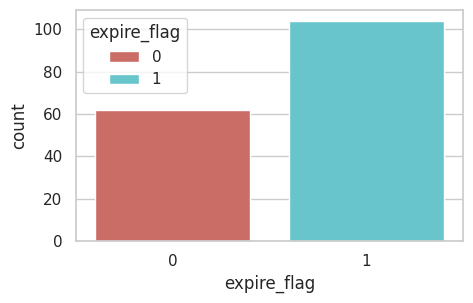

<Figure size 640x480 with 0 Axes>

In [189]:
plt.figure(figsize= (5,3))
sns.countplot(x='expire_flag',hue ='expire_flag',data=final_df,palette ='hls')
plt.show()
plt.savefig('count')

**Therefore, classes are slighty imblanced and can impact the accuracy of the model. Oversampling will be used to increase the number of survived patients**

In [190]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Handling any remaining missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
final_df_imputed = imputer.fit_transform(final_df)

final_df_imputed = pd.DataFrame(final_df_imputed, columns=final_df.columns)

# Separating features and target variable
X = final_df_imputed.drop(columns=['expire_flag'])  # Features
y = final_df_imputed['expire_flag']  # Target variable

# Applying SMOTE to oversample the minority class due to data imbalance
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Checking the class distribution after oversampling
print(y_resampled.value_counts())

expire_flag
1.0    104
0.0    104
Name: count, dtype: int64


# Model Training

**Input and target data**

In [191]:
#Target variable
X = X_resampled
y = y_resampled

# Train-test Split

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5)

print("# of data samples for training:", len(X_train))
# print("# of data samples for validation:", len(X_val))
print("# of data samples for testing:", len(X_test))

# of data samples for training: 166
# of data samples for testing: 42


# Logistic Regression

In [193]:
model_lr = LogisticRegression(max_iter=100000)
model_lr.fit(X_train,y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)*100
print('Logistic Regression Accuracy:', accuracy_lr)

Logistic Regression Accuracy: 73.80952380952381


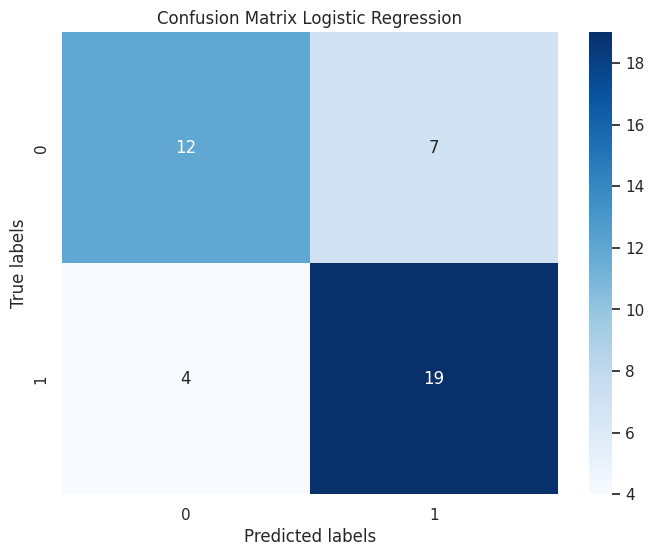

In [194]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_lr)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Logistic Regression')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83        21
         1.0       0.82      0.86      0.84        21

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42



# Desicion Trees

In [195]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train,y_train)

y_pred_dt = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)*100
print('Decision Trees Accuracy:', accuracy_dt)

Decision Trees Accuracy: 61.904761904761905


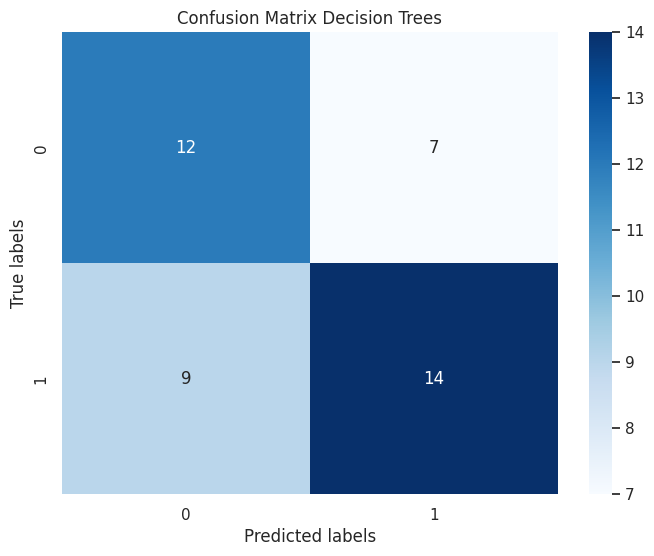

In [196]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_dt)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Decision Trees')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [197]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.57      0.63      0.60        19
         1.0       0.67      0.61      0.64        23

    accuracy                           0.62        42
   macro avg       0.62      0.62      0.62        42
weighted avg       0.62      0.62      0.62        42



# Random Forest

In [198]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=10)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)*100
print('Random Forest Accuracy:', accuracy_rf)

Random Forest Accuracy: 71.42857142857143


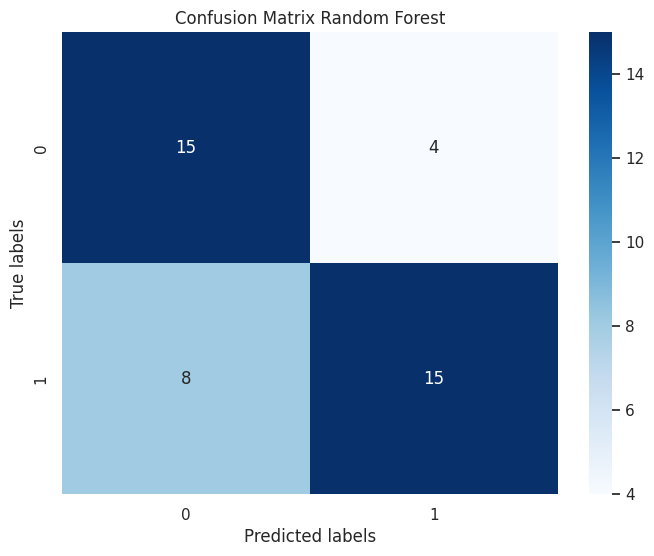

In [199]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_rf)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93        21
         1.0       0.95      0.90      0.93        21

    accuracy                           0.93        42
   macro avg       0.93      0.93      0.93        42
weighted avg       0.93      0.93      0.93        42



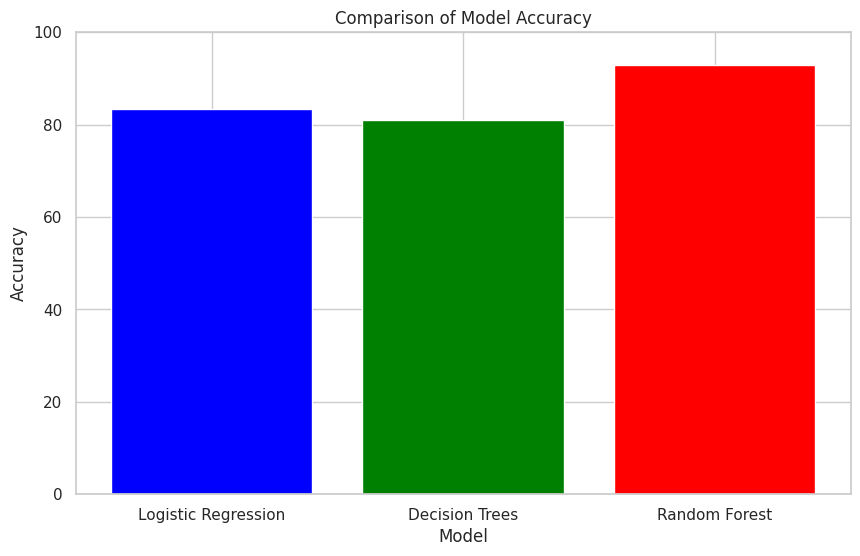

In [ ]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression', 'Decision Trees', 'Random Forest', ]
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.ylim(0, 100)
plt.show()